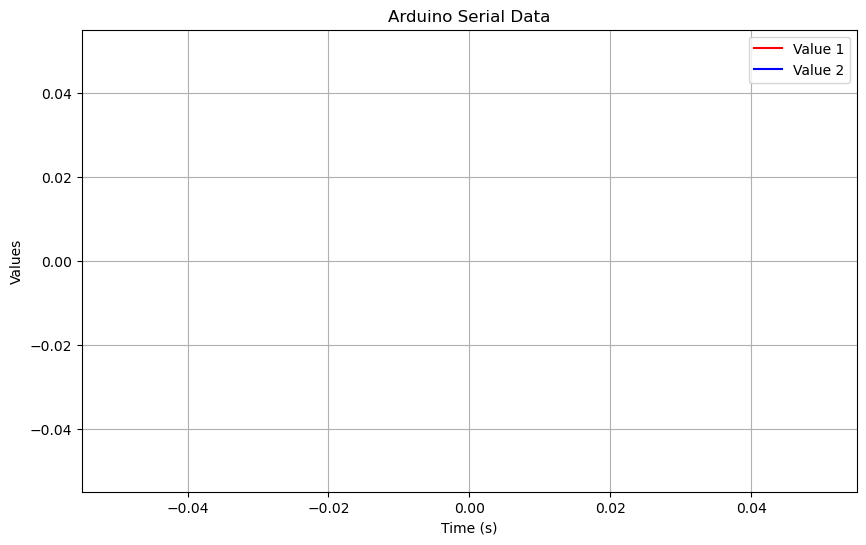

Stopping live plot.


In [5]:
import serial
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
from IPython.display import display, clear_output
import time

# Configuration parameters - adjust these as needed
SERIAL_PORT = "/dev/cu.usbserial-110"  # Change this to match your Arduino port (e.g., 'COM3' on Windows)
BAUD_RATE = 9600             # Make sure this matches the baud rate in your Arduino sketch
MAX_POINTS = 100             # Number of points to display on the plot

# Initialize the data arrays
times = np.array([])
values1 = np.array([])
values2 = np.array([])

# Set up the plot in interactive mode
plt.ion()
fig, ax = plt.subplots(figsize=(10, 6))
line1, = ax.plot([], [], 'r-', label='Value 1')
line2, = ax.plot([], [], 'b-', label='Value 2')

# Add labels and legend
ax.set_xlabel('Time (s)')
ax.set_ylabel('Values')
ax.set_title('Arduino Serial Data')
ax.legend()
ax.grid(True)

# Initialize the serial connection
try:
    ser = serial.Serial(SERIAL_PORT, BAUD_RATE, timeout=1)
    # Give the Arduino time to reset after opening the serial connection
    time.sleep(2)
    print(f"Connected to Arduino on {SERIAL_PORT}")
except serial.SerialException as e:
    print(f"Error opening serial port: {e}")
    raise

# Start time
start_time = time.time()

# Function to update the plot
def update_plot():
    global times, values1, values2, start_time

    # Clear buffer of any previous data
    ser.reset_input_buffer()

    try:
        # Read data from serial
        if ser.in_waiting > 0:
            line = ser.readline().decode('utf-8').strip()

            # Parse the data (assuming values are space or comma separated)
            # Modify this parsing logic based on your Arduino's output format
            try:
                # Try comma-separated first
                if ',' in line:
                    data = line.split(',')
                    if len(data) >= 2:
                        val1 = float(data[0])
                        val2 = float(data[1])
                # Try space-separated if comma doesn't work
                else:
                    data = line.split()
                    if len(data) >= 2:
                        val1 = float(data[0])
                        val2 = float(data[1])

                # Calculate time elapsed
                current_time = time.time() - start_time

                # Append new data
                times = np.append(times, current_time)
                values1 = np.append(values1, val1)
                values2 = np.append(values2, val2)

                print(values1)
                # Keep only the last MAX_POINTS
                if len(times) > MAX_POINTS:
                    times = times[-MAX_POINTS:]
                    values1 = values1[-MAX_POINTS:]
                    values2 = values2[-MAX_POINTS:]

                # Update the plot
                line1.set_data(times, values1)
                line2.set_data(times, values2)

                # Adjust plot limits
                ax.set_xlim(times.min(), times.max())
                y_min = min(values1.min() if len(values1) > 0 else 0, 
                           values2.min() if len(values2) > 0 else 0)
                y_max = max(values1.max() if len(values1) > 0 else 1, 
                           values2.max() if len(values2) > 0 else 1)
                margin = (y_max - y_min) * 0.1
                ax.set_ylim(y_min - margin, y_max + margin)

                # Redraw the plot
                fig.canvas.draw()
                fig.canvas.flush_events()

                # Print the latest values (optional)
                print(f"Time: {current_time:.2f}s, Value 1: {val1}, Value 2: {val2}")

            except (ValueError, IndexError) as e:
                print(f"Error parsing data: {line} ({e})")

    except Exception as e:
        print(f"Error reading from serial: {e}")

# Main loop for Jupyter notebook
try:
    print("Starting live plot. Press Ctrl+C to stop.")
    while True:
        update_plot()
        clear_output(wait=True)
        display(fig)
        # Adjust this delay to control how often the plot updates
        time.sleep(0.1)
except KeyboardInterrupt:
    print("Stopping live plot.")
finally:
    # Clean up
    ser.close()
    plt.ioff()
    plt.close(fig)

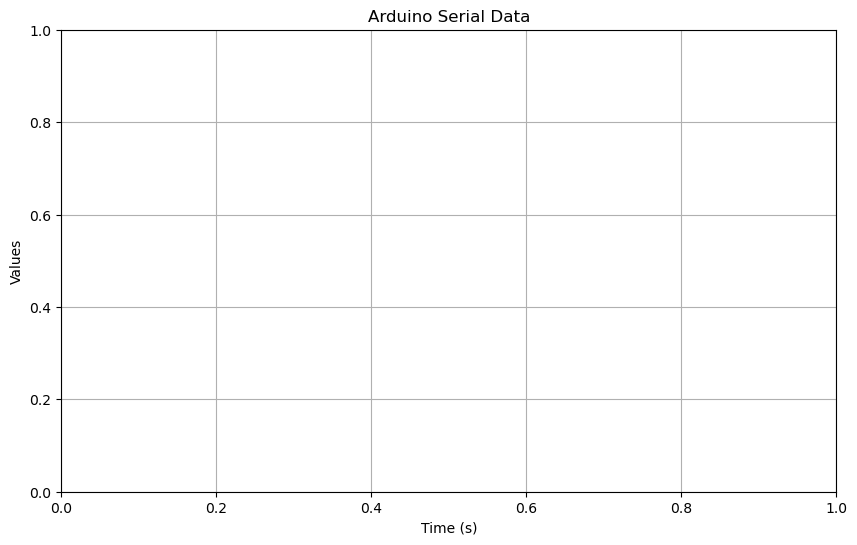


Stopping live plot.
Serial connection closed.


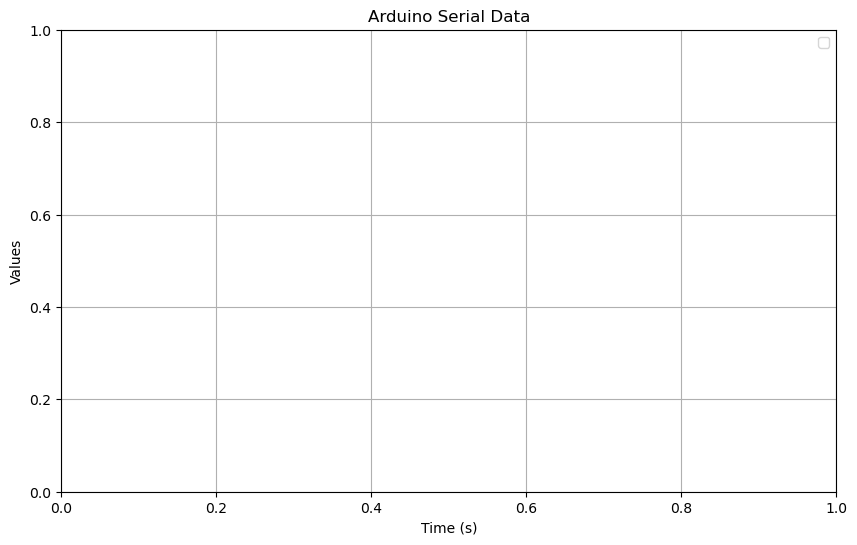


Stopping data collection.
Serial connection closed.


In [9]:
import serial
import matplotlib.pyplot as plt
import numpy as np
import time
from IPython.display import clear_output


def run_serial_plot(port_name, baud_rate=9600, max_points=100):
    # Initialize data arrays
    times = []
    values1 = []
    values2 = []

    # Open serial connection
    try:
        ser = serial.Serial(port_name, baud_rate, timeout=1)
        print(f"Connected to {port_name} at {baud_rate} baud")
        time.sleep(2)  # Give Arduino time to reset
    except Exception as e:
        print(f"Error opening serial port: {e}")
        return

    # Start time reference
    start_time = time.time()

    # Set initial plot y-limits with a very wide range to ensure data is visible
    y_min, y_max = -10, 10

    try:
        print("Reading serial data. Press Ctrl+C to stop.")

        while True:
            # Check for serial data
            if ser.in_waiting > 0:
                # Read data
                try:
                    line = ser.readline().decode("utf-8").strip()
                    print(f"Raw data: {line}")  # Debug print

                    # Parse data (try both space and comma separation)
                    if "," in line:
                        parts = line.split(",")
                    else:
                        parts = line.split()

                    if len(parts) >= 2:
                        # Convert to float
                        try:
                            val1 = float(parts[0])
                            val2 = float(parts[1])

                            # Record time
                            current_time = time.time() - start_time

                            # Add to data arrays
                            times.append(current_time)
                            values1.append(val1)
                            values2.append(val2)

                            # Keep only max_points
                            if len(times) > max_points:
                                times = times[-max_points:]
                                values1 = values1[-max_points:]
                                values2 = values2[-max_points:]

                            # Debug print
                            print(f"Time: {current_time:.2f}s, Values: {val1}, {val2}")

                            # Update y-axis limits based on all data seen so far
                            # This ensures the scale captures all values
                            if val1 < y_min:
                                y_min = val1 - abs(val1 * 0.1)
                            if val2 < y_min:
                                y_min = val2 - abs(val2 * 0.1)
                            if val1 > y_max:
                                y_max = val1 + abs(val1 * 0.1)
                            if val2 > y_max:
                                y_max = val2 + abs(val2 * 0.1)

                            # Add some padding to ensure values at the edges are visible
                            range_y = y_max - y_min
                            if range_y < 1:  # If range is very small
                                y_min -= 0.5
                                y_max += 0.5
                        except ValueError as e:
                            print(f"Error converting values: {e}")
                except Exception as e:
                    print(f"Error processing line: {e}")

            # Create new plot
            plt.figure(figsize=(10, 6))

            if len(times) > 0:
                plt.plot(times, values1, "r-", label="Value 1", linewidth=2)
                plt.plot(times, values2, "b-", label="Value 2", linewidth=2)

                # Set x-axis limits to show latest data
                if len(times) > 1:
                    time_range = times[-1] - times[0]
                    plt.xlim(max(0, times[-1] - min(time_range, 10)), times[-1] + 0.5)

                # Set y-axis limits with the dynamically updated values
                plt.ylim(y_min, y_max)

                # Debug print of plot limits
                print(f"Plot y-limits: {y_min} to {y_max}")

            # Add labels and styling
            plt.xlabel("Time (s)")
            plt.ylabel("Values")
            plt.title("Arduino Serial Data")
            plt.grid(True)
            plt.legend()

            # Display plot
            clear_output(wait=True)
            display(plt.gcf())
            plt.close()

            # Small delay
            time.sleep(0.2)

    except KeyboardInterrupt:
        print("\nStopping data collection.")
    finally:
        if ser and ser.is_open:
            ser.close()
            print("Serial connection closed.")


# Example usage:
run_serial_plot('/dev/cu.usbserial-110')

In [ ]:
from serial import Serial

ser = Serial('/dev/cu.usbserial-110', 9600)

while True:
    data = ser.readline()
    t, value = data.decode().strip().split(',')


In [16]:
from serial import Serial
import matplotlib.pyplot as plt
import numpy as np
from IPython import display

# Set up matplotlib for interactive mode
plt.ion()

# Create figure and axis objects
fig, ax = plt.subplots(figsize=(10, 6))
(line,) = ax.plot([], [])
ax.set_xlabel("Time")
ax.set_ylabel("Value")
ax.set_title("Live Serial Data")
ax.grid(True)

# Initialize data containers
time_data = []
value_data = []


# Set up the plot
def setup_plot():
    ax.set_xlim(0, 10)  # Initial x-range
    ax.set_ylim(0, 100)  # Initial y-range
    return line


# Update the plot with new data
def update_plot():
    # Update the line data
    line.set_xdata(time_data)
    line.set_ydata(value_data)

    # Adjust the plot limits if needed
    if time_data:
        ax.set_xlim(max(0, time_data[-1] - 50), time_data[-1] + 10)
        ax.set_ylim(min(min(value_data), 0) - 10, max(max(value_data), 100) + 10)

    # Draw the updated plot
    fig.canvas.draw()
    fig.canvas.flush_events()

    # Display the plot in the notebook
    display.clear_output(wait=True)
    display.display(plt.gcf())


# Initialize serial connection
ser = Serial("/dev/cu.usbserial-110", 9600)

# Setup the plot
line = setup_plot()

# Main loop
try:
    while True:
        # Read data from serial port
        data = ser.readline()

        # Parse the data
        try:
            t_str, value_str = data.decode().strip().split(",")
            t = float(t_str)
            value = float(value_str)

            # Append data to lists
            time_data.append(t)
            value_data.append(value)

            # Update the plot
            update_plot()

        except (ValueError, UnicodeDecodeError) as e:
            print(f"Error parsing data: {e}")
            continue

except KeyboardInterrupt:
    print("Data collection stopped by user")
finally:
    # Close the serial connection when done
    ser.close()
    # Turn off interactive mode
    plt.ioff()

Data collection stopped by user


Data collection stopped by user


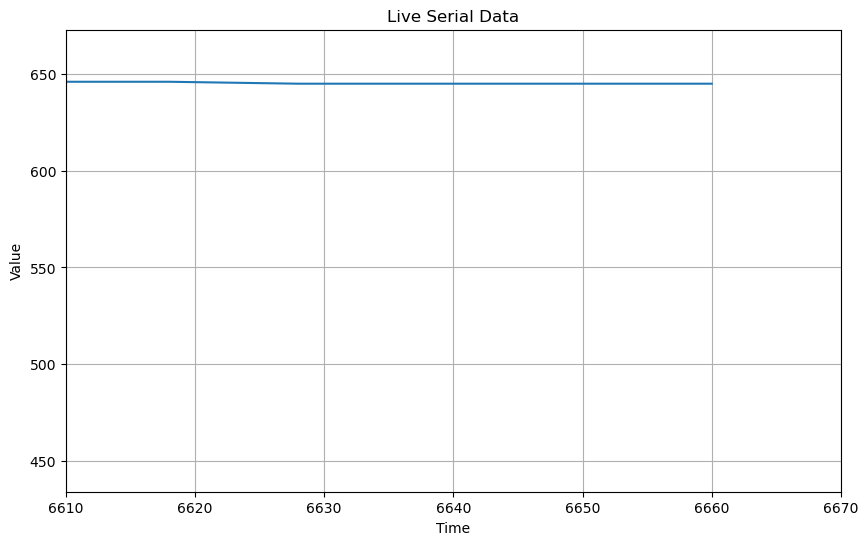

In [3]:
from serial import Serial
import matplotlib.pyplot as plt
import numpy as np
from IPython import display

# Set up matplotlib for interactive mode
plt.ion()

# Create figure and axis objects
fig, ax = plt.subplots(figsize=(10, 6))
(line,) = ax.plot([], [])
ax.set_xlabel("Time")
ax.set_ylabel("Value")
ax.set_title("Live Serial Data")
ax.grid(True)

# Initialize data containers
time_data = []
value_data = []


# Set up the plot
def setup_plot():
    ax.set_xlim(0, 10)  # Initial x-range
    ax.set_ylim(0, 1)  # Initial y-range (will be adjusted)
    return line


# Update the plot with new data
def update_plot():
    # Update the line data
    line.set_xdata(time_data)
    line.set_ydata(value_data)

    # Adjust the x-axis limits if needed
    if time_data:
        ax.set_xlim(max(0, time_data[-1] - 50), time_data[-1] + 10)

        # Dynamically adjust y-axis with 10% padding
        if len(value_data) > 1:
            y_min = min(value_data)
            y_max = max(value_data)
            y_range = y_max - y_min

            # If range is very small, expand it to prevent excessive zoom
            if y_range < 1e-10:
                y_range = 1.0

            # Add padding (10% of the range on each side)
            padding = y_range * 0.1
            ax.set_ylim(y_min - padding, y_max + padding)

    # Draw the updated plot
    fig.canvas.draw()
    fig.canvas.flush_events()

    # Display the plot in the notebook
    display.clear_output(wait=True)
    display.display(plt.gcf())


# Initialize serial connection
ser = Serial("/dev/cu.usbserial-110", 9600)

# Setup the plot
line = setup_plot()

# Main loop
try:
    while True:
        # Read data from serial port
        data = ser.readline()

        # Parse the data
        try:
            t_str, value_str = data.decode().strip().split(",")
            t = float(t_str)
            value = float(value_str)

            # Append data to lists
            time_data.append(t)
            value_data.append(value)

            # Update the plot
            update_plot()

        except (ValueError, UnicodeDecodeError) as e:
            print(f"Error parsing data: {e}")
            continue

except KeyboardInterrupt:
    print("Data collection stopped by user")
finally:
    # Close the serial connection when done
    ser.close()
    # Turn off interactive mode
    plt.ioff()

In [4]:
from serial import Serial
import numpy as np
from ipywidgets import HBox, VBox, Button, IntSlider, Label, Layout
from bqplot import Figure, LinearScale, Lines, Axis
import time
import threading

# Initialize data containers
time_data = []
value_data = []
plot_data_lock = threading.Lock()  # For thread safety

# Create scales
x_scale = LinearScale()
y_scale = LinearScale()

# Create a line mark
line = Lines(
    x=time_data,
    y=value_data,
    scales={"x": x_scale, "y": y_scale},
    colors=["blue"],
    stroke_width=2,
)

# Create axes
ax_x = Axis(scale=x_scale, label="Time", grid_lines="solid")
ax_y = Axis(scale=y_scale, label="Value", orientation="vertical", grid_lines="solid")

# Create figure
fig = Figure(
    marks=[line],
    axes=[ax_x, ax_y],
    title="Live Serial Data",
    animation_duration=200,
    fig_margin={"top": 50, "bottom": 60, "left": 60, "right": 30},
    layout={"width": "800px", "height": "500px"},
)

# Controls
stop_button = Button(description="Stop Data Collection")
update_rate_slider = IntSlider(
    value=500,
    min=100,
    max=2000,
    step=100,
    description="Update Rate (ms):",
    layout=Layout(width="50%"),
)
max_points_slider = IntSlider(
    value=100,
    min=10,
    max=500,
    step=10,
    description="Display Points:",
    layout=Layout(width="50%"),
)

# Flags for control
stop_collecting = False
update_rate_ms = 500  # Update plot every 500ms
max_points = 100  # Maximum number of points to display


def on_button_clicked(b):
    global stop_collecting
    stop_collecting = True
    b.description = "Stopping..."


def on_update_rate_change(change):
    global update_rate_ms
    update_rate_ms = change["new"]


def on_max_points_change(change):
    global max_points
    max_points = change["new"]


# Connect callbacks
stop_button.on_click(on_button_clicked)
update_rate_slider.observe(on_update_rate_change, names="value")
max_points_slider.observe(on_max_points_change, names="value")

# Display figure and controls
display(VBox([fig, HBox([stop_button]), HBox([update_rate_slider, max_points_slider])]))


# Function to update the plot (will be called periodically)
def update_plot():
    global time_data, value_data

    # Make a copy of the current data for thread safety
    with plot_data_lock:
        x_data = time_data.copy()
        y_data = value_data.copy()

    # Update the plot data
    line.x = x_data
    line.y = y_data

    # Dynamically adjust axis limits
    if len(x_data) > 1:
        # X-axis
        x_min = max(0, x_data[-1] - 50)
        x_max = x_data[-1] + 10
        x_scale.min = x_min
        x_scale.max = x_max

        # Y-axis with padding
        y_min = min(y_data)
        y_max = max(y_data)
        y_range = max(y_max - y_min, 1e-10)  # Prevent zero range
        padding = y_range * 0.1
        y_scale.min = y_min - padding
        y_scale.max = y_max + padding


# Function for data collection thread
def collect_data():
    global time_data, value_data, stop_collecting

    # Initialize serial connection
    ser = Serial("/dev/cu.usbserial-110", 9600)

    try:
        while not stop_collecting:
            # Read data from serial port
            data = ser.readline()

            # Parse the data
            try:
                t_str, value_str = data.decode().strip().split(",")
                t = float(t_str)
                value = float(value_str)

                # Update the data with thread safety
                with plot_data_lock:
                    time_data.append(t)
                    value_data.append(value)

                    # Limit the number of points for memory management
                    if len(time_data) > max_points:
                        time_data = time_data[-max_points:]
                        value_data = value_data[-max_points:]

            except (ValueError, UnicodeDecodeError) as e:
                print(f"Error parsing data: {e}")
                continue

    except Exception as e:
        print(f"Error in data collection: {e}")
    finally:
        # Close the serial connection when done
        ser.close()
        print("Serial connection closed")


# Function for plot update thread
def update_plot_periodically():
    global stop_collecting

    while not stop_collecting:
        update_plot()
        time.sleep(update_rate_ms / 1000)  # Convert ms to seconds


# Start the threads
data_thread = threading.Thread(target=collect_data)
plot_thread = threading.Thread(target=update_plot_periodically)

data_thread.daemon = True
plot_thread.daemon = True

data_thread.start()
plot_thread.start()

# Let the user know we've started
print(
    "Data collection and visualization started. Use the slider to adjust update speed."
)

Data collection and visualization started. Use the slider to adjust update speed.


Error in data collection: read failed: [Errno 6] Device not configured
Serial connection closed
